# Homework 2, BEE 6940 (Due By 2/23/23, 9:00PM)

**Name**: Demola Ogunnaike 

**ID**: dko22 (5023990)

## Overview

### Instructions

- Problem 1 asks you to use `Optimize.optim()` to calibrate a semi-empirical sea-level rise model to temperature and sea-level data.
- Problem 2 asks you to use SNEASY, a Simple Nonlinear EArth SYstem model, to propagate climate-system uncertainty through to sea-level rise.

### Load Environment

The following code loads the environment and makes sure all needed packages are installed. This should be at the start of most Julia scripts.

In [9]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `c:\Users\demol\Documents\BEE 6940\hw2-DemolaASC5`


## Problems (Total: 100 Points)

### Problem 1 (60 points)

In this problem, we will work with the semi-empirical sea-level model from [Rahmstorf (2007)](https://doi.org/10.1073/pnas.0907765106). This model links global mean temperature $T(t)$ to global mean sea-level $H(t)$ through the equation:

$$\frac{dH(t)}{dt} = \alpha (T(t) - T_0),$$

where $T_0$ is the temperature (in $^\circ C$) where sea-level is in equilibrium ($dH/dt = 0$), and $\alpha$ is the sea-level rise sensitivity to temperature. Discretizing this equation using the Euler method and using an annual timestep ($\delta t = 1$), we get

$$H(t+1) = H(t) + \alpha (T(t) - T_0).$$

Our goal in this problem is to load temperature and sea-level datasets and *calibrate* the model by finding parameter values which are consistent with historical observations. We will select parameters which minimize the root-mean-square-error (RMSE) of the data-model residuals. The following function can be used to compute the RMSE.

In [10]:
using Statistics

rmse(y, ŷ) = sqrt(mean((y - ŷ).^2))

rmse (generic function with 1 method)

#### Problem 1.1 (15 points)

Load the sea-level and temperature datasets into `DataFrame`s. The sea-level dataset is provided in `data/CSIRO_Recons_gmsl_yr_2015.csv`, and the temperature dataset is provided in `data/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv`. You'll need to correct the years in the sea-level rise data to remove the half-year, and then align the two data sets on the common period 1880 &ndash; 2013. Plot each of the resulting data sets after this "cleaning" process on different axes.

In [11]:
using DataFrames
using CSVFiles
using Plots

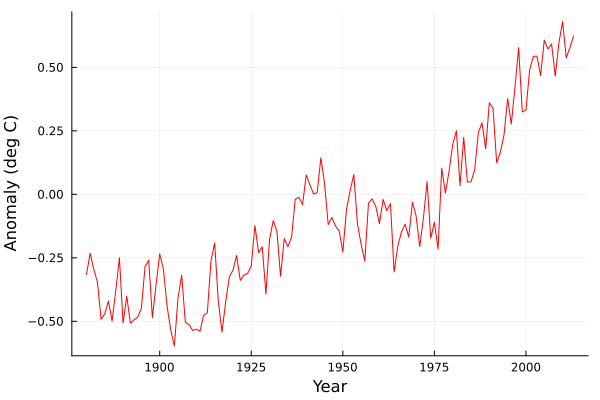

In [12]:
sea_level_data = DataFrame(load("data/CSIRO_Recons_gmsl_yr_2015.csv"))
temperature_data = DataFrame(load("data/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv"))
sea_level_data[:, :Time] = sea_level_data[:, :Time] .- 0.5; 
data = leftjoin(sea_level_data, temperature_data, on="Time")
select!(data, [1, 2, 4])
plot(data[:,:Time], data."Anomaly (deg C)", color=:red, legend=false) 
xlabel!("Year")
ylabel!("Anomaly (deg C)")

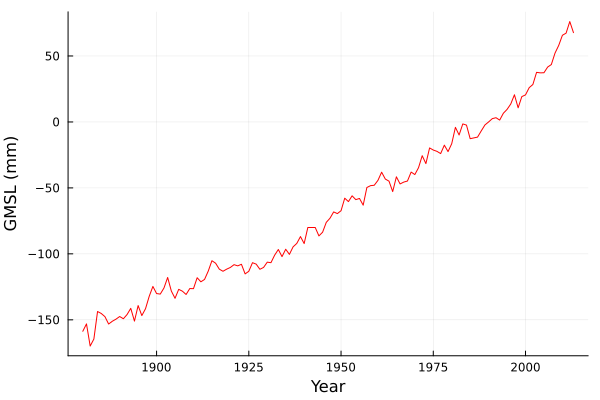

In [13]:
plot(data[:,:Time], data."GMSL (mm)", color=:red, legend=false) 
xlabel!("Year")
ylabel!("GMSL (mm)")

In [14]:
print(describe(data))

3×7 DataFrame
 Row │ variable         mean         min          median       max          nmissing  eltype                  
     │ Symbol           Float64      Float64      Float64      Float64      Int64     Type                    
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Time             1946.5       1880.0       1946.5       2013.0              0  Float64
   2 │ GMSL (mm)         -66.0813    -169.9        -74.55        76.1              0  Float64
   3 │ Anomaly (deg C)    -0.082547    -0.597561    -0.123748     0.680371         0  Union{Missing, Float64}

#### Problem 1.2 (30 points)

Write a function for the above model, and find the parameter values which minimize the RMSE using `Optim.optimize()` (here is [documentation on how to use `Optim.optimize()` to minimize a function](https://julianlsolvers.github.io/Optim.jl/v0.9.3/user/minimization/). This will involve writing a function which takes in a vector of parameter values and the data, simulates the model, and computes the RMSE. `Optim.optimize()` maps a parameter vector to a function, and since you'll be passing auxiliary data to your function, you may want to use anonymous function to wrap your simulation function, as in

```julia
optimize(p -> f(p, aux), ...)
```

In [15]:
function rahmstorf_model(α, T₀, H₀, temp_data)
    temp_effect = α .* (temp_data .- T₀)
    slr_predict = cumsum(temp_effect) .+ H₀
    return slr_predict
end

rahmstorf_model (generic function with 1 method)

In [16]:
using Optim;
rmse(y, ŷ) = sqrt(mean((y .- ŷ).^2))
# optimize using a parameter p, with p[1] = α and p[2] = T₀

years = data[:, 1]
sealevels = data[:, 2]
temp = data[:, 3]

function minimize_mse(p, temp, sealevels)
    predict = rahmstorf_model(p[1], p[2], p[3], temp)
    return rmse(predict, sealevels)
end

optim_out = Optim.optimize(p -> minimize_mse(p, temp, sealevels), [1.0, 0.0, 0.0])
params = Optim.minimizer(optim_out)
@show params;

params = [1.8636596824562823, -0.9711430993147957, -157.33666238607228]


#### Problem 1.3 (15 points)

Plot the sea-level data as points, and overlay a line with the model hindcast. How well do you think the model fits the data? Are there any key trends or features that you notice?

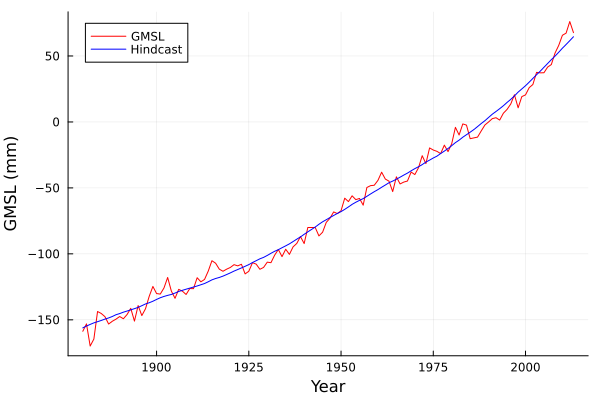

In [45]:
hindcast = rahmstorf_model(params[1], params[2], params[3], temp)
plot(years, data."GMSL (mm)", color=:red, label="GMSL") 
plot!(years, hindcast, color=:blue, label="Hindcast") 
xlabel!("Year")
ylabel!("GMSL (mm)")

The model fits the data relatively well. It appears that the hindcast removes "noisy components" of the GMSL model. 

### Problem 2 (40 points)

Your goal in this problem is to see how scenario and parametric uncertainty in climate models propagates through the simple semi-empirical sea-level model from Problem 1. You'll be using SNEASY, and we have provided the same set of functions in `src/sneasy_model_functions.jl` that you used in Lab 3.

#### Problem 2.1 (10 points)

Use 1000 samples from the parameter set for MimiSNEASY (found in `params/parameters_subsample_sneasybrick.csv`) to compute and plot 95% uncertainty intervals for global mean temperatures from 1880 &ndash; 2100 for RCPs 2.6, 4.5, 6.0, and 8.5.

In [18]:
using Mimi
using MimiSNEASY
using CSVFiles
using DataFrames
using Plots

include("src/sneasy_model_functions.jl") # load helper functions
# set up array of model years; this aligns with defaults, but we'll want to use this to query and normalize later
start_year = 1880
end_year = 2100
model_years = collect(start_year:end_year);

In [19]:
using StatsBase
using Random

parameters = DataFrame(load(joinpath(@__DIR__, "params","parameters_subsample_sneasybrick.csv")));
Random.seed!(1)

n_sample = 1000
# get subsample
sample_index = sample(1:nrow(parameters), n_sample, replace=true)
param_sample = parameters[sample_index, :]

Row,sd_temp,sd_ocean_heat,sd_glaciers,sd_greenland,sd_antarctic,sd_gmsl,sigma_whitenoise_co2,rho_temperature,rho_ocean_heat,rho_glaciers,rho_greenland,rho_antarctic,rho_gmsl,alpha0_CO2,CO2_0,N2O_0,temperature_0,ocean_heat_0,thermal_s0,greenland_v0,glaciers_v0,glaciers_s0,antarctic_s0,Q10,CO2_fertilization,CO2_diffusivity,heat_diffusivity,rf_scale_aerosol,climate_sensitivity,thermal_alpha,greenland_a,greenland_b,greenland_alpha,greenland_beta,glaciers_beta0,glaciers_n,anto_alpha,anto_beta,antarctic_gamma,antarctic_alpha,antarctic_mu,antarctic_nu,antarctic_precip0,antarctic_kappa,antarctic_flow0,antarctic_runoff_height0,antarctic_c,antarctic_bed_height0,antarctic_slope,antarctic_lambda,antarctic_temp_threshold
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0755502,2.29768,0.000176297,0.000242539,0.000422743,0.0019441,0.177955,0.51542,0.775477,0.361872,0.981943,0.955383,0.966817,0.0106371,280.864,281.321,0.0135978,-25.5854,0.0266672,7.42544,0.42337,0.0148887,-0.0138484,1.91057,0.444302,137.386,2.85965,1.14249,3.30431,0.163685,-3.61984,8.47078,0.000259697,2.20302e-5,0.000993467,0.849177,0.277691,0.0601361,2.00172,0.00745795,9.05948,0.0103882,0.875177,0.0706762,1.54711,1345.52,134.269,780.512,0.000625146,0.015013,-15.7924
2,0.0769636,2.65031,0.000385736,0.000246513,0.00023947,0.00260424,0.234941,0.399054,-0.154619,-0.340628,0.944757,0.973352,0.992432,0.0123346,280.674,274.945,0.00677597,-25.5866,0.00561213,7.19373,0.422944,-0.0362155,0.0296497,1.11226,0.447961,18.9862,2.82556,1.04095,2.60317,0.165319,-1.76076,7.85641,0.00063713,1.37906e-5,0.000760921,0.560387,0.062157,1.87047,2.62476,0.457237,7.47942,0.0084933,0.211044,0.0507022,0.775784,1130.36,134.065,785.215,0.000562837,0.0147177,-16.0334
3,0.0700222,2.79481,0.000184552,0.000237602,0.000305979,0.00245654,0.245577,0.562374,0.900661,0.461198,0.931037,0.986946,0.856499,0.0123355,279.729,268.38,0.00816288,-27.5696,-0.0340652,7.26506,0.422777,-0.0477084,0.0551208,1.31493,0.433893,33.2591,3.10102,0.811083,2.11046,0.176358,-2.52993,8.25956,0.000404878,4.7285e-5,0.000784887,0.85128,0.753974,1.41589,1.66711,0.0040947,13.5556,0.00348155,1.00848,0.0389985,1.41174,1395.54,110.143,781.746,0.000719877,0.00831126,-15.2422
4,0.0709972,3.98875,0.000433161,0.000287722,0.000420768,0.000738401,0.218484,0.493301,0.249099,0.14598,0.94189,0.927042,0.888178,0.0194794,280.941,279.46,-0.00405242,-33.1176,-0.0156447,7.29674,0.425369,0.0607848,-0.0314791,2.04416,0.632643,17.5539,2.80963,0.757621,2.1225,0.173138,-2.642,8.64285,0.000601935,1.41408e-5,0.000973341,0.932478,0.0720675,0.216053,0.997051,0.105145,9.41965,0.00643363,1.27137,0.0668328,1.37654,1335.78,138.414,792.24,0.00069792,0.013471,-15.5845
5,0.0927277,2.99512,0.000281065,0.000273221,0.000509956,0.00211841,0.241314,0.564962,0.34959,0.172244,0.93085,0.96153,0.997383,0.012068,280.584,270.447,0.00879359,-24.8341,0.00780505,7.2237,0.442453,0.0238444,0.0341163,1.12391,0.297431,54.7014,3.68704,1.21594,3.50398,0.17351,-1.1215,7.62919,0.000742625,0.000275234,0.000907189,0.584394,0.0564583,1.40707,2.35111,0.304408,12.8477,0.00938458,0.942794,0.0530621,1.7304,1678.23,102.961,752.209,0.000617178,0.00994721,-15.2342
6,0.0803532,2.44743,0.000443241,0.000263646,0.000466575,1.40668e-5,0.371835,0.520583,0.633753,-0.223466,0.874665,0.894582,0.647162,0.0167651,280.798,280.912,0.0708785,-18.7676,-0.0360955,7.22033,0.345812,-0.028361,0.0371832,1.0261,0.471944,14.0199,2.58791,1.36789,3.24714,0.16615,-1.20573,7.61404,0.000793053,0.00030385,0.00109182,0.985644,0.0337862,0.656089,2.64238,0.223893,8.12672,0.00800306,1.3742,0.0487233,1.52863,1607.97,141.664,757.556,0.000714244,0.0117284,-16.1707
7,0.0802124,1.261

In [20]:
function generate_model(rcp_scenario)
    m = create_sneasy_model(rcp_scenario=rcp_scenario, start_year=start_year, end_year=end_year)
    set_sneasy_params!(m, parameters[6340, :], names(parameters))
    run(m)
    return m
end

generate_model (generic function with 1 method)

In [21]:
scenarios = ["RCP 2.6","RCP 4.5","RCP 6.0","RCP 8.5"]
query_years = 1880:2100
rcp26 = generate_model("RCP26")
rcp45 = generate_model("RCP45")
rcp60 = generate_model("RCP60")
rcp85 = generate_model("RCP85")

rcp_models = [rcp26, rcp45, rcp60, rcp85]
temps_array = []
for i = 1:length(scenarios)
    append!(temps_array,[query_temperature(rcp_models[i], model_years, query_years)])
end 

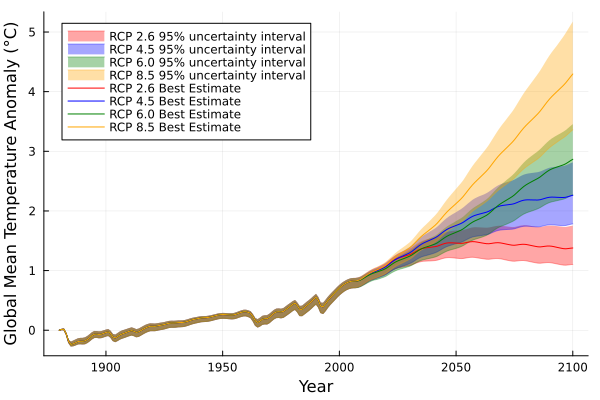

In [22]:
for scenario = 1:length(scenarios)
    temps = zeros(n_sample, length(query_years))
    for i = 1:n_sample
        m = rcp_models[scenario]
        set_sneasy_params!(m, parameters[i, :], names(parameters))
        run(m)
        temps[i, :] = query_temperature(m, model_years, query_years)
    end
    temp_quantiles = mapslices(x -> quantile(x, [0.025, 0.975]), temps, dims=1)
    if scenarios[scenario] == "RCP 2.6"
        plot(query_years, temp_quantiles[1, :], fillrange=temp_quantiles[2, :], fillalpha=0.35, alpha =0.35, color=:red, label="RCP 2.6 95% uncertainty interval")
    end 
    if scenarios[scenario] == "RCP 4.5"
        plot!(query_years, temp_quantiles[1, :], fillrange=temp_quantiles[2, :], fillalpha=0.35, alpha =0.35, color=:blue, label="RCP 4.5 95% uncertainty interval")
    end 
    if scenarios[scenario]== "RCP 6.0"
        plot!(query_years, temp_quantiles[1, :], fillrange=temp_quantiles[2, :], fillalpha=0.35, alpha =0.35, color=:green, label="RCP 6.0 95% uncertainty interval")
    end 
    if scenarios[scenario] == "RCP 8.5"
        plot!(query_years, temp_quantiles[1, :], fillrange=temp_quantiles[2, :], fillalpha=0.35, alpha =0.35, color=:orange, label="RCP 8.5 95% uncertainty interval")
    end  
end 
plot!(query_years, temps_array[1], color=:red, label= "RCP 2.6 Best Estimate") 
plot!(query_years, temps_array[2], color=:blue, label= "RCP 4.5 Best Estimate") 
plot!(query_years, temps_array[3], color=:green, label= "RCP 6.0 Best Estimate") 
plot!(query_years, temps_array[4], color=:orange, label= "RCP 8.5 Best Estimate") 
xlabel!("Year")
ylabel!("Global Mean Temperature Anomaly (°C)")

#### Problem 2.2 (10 points)

Run your calibrated model from Problem 1 on the ensemble of temperatures for each RCP from Problem 2.1. Plot the 95% uncertainty intervals and the median trajectory from 1880 & ndash;.

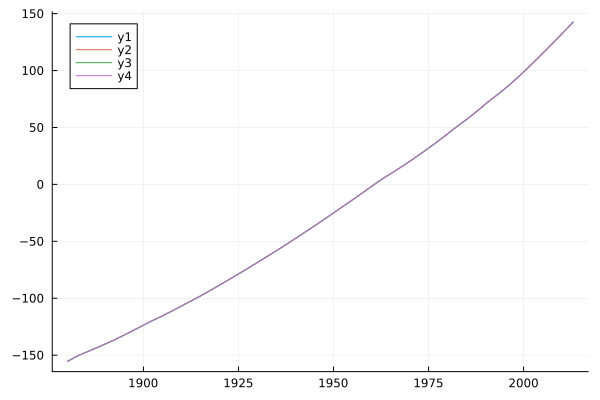

In [53]:
rcp_calib26 = rahmstorf_model(params[1], params[2], params[3], temps_array[1])[1:length(years)]
rcp_calib45 = rahmstorf_model(params[1], params[2], params[3], temps_array[2])[1:length(years)]
rcp_calib60 = rahmstorf_model(params[1], params[2], params[3], temps_array[3])[1:length(years)]
rcp_calib85 = rahmstorf_model(params[1], params[2], params[3], temps_array[4])[1:length(years)]
plot(years,rcp_calib26)
plot!(years,rcp_calib45)
plot!(years,rcp_calib60)
plot!(years,rcp_calib85)

Since all of the models have the same ensemble of temperatures for each RCP from Problem 2.1, we'll use only 1 to plot the 95% uncertainty interval from 1880.

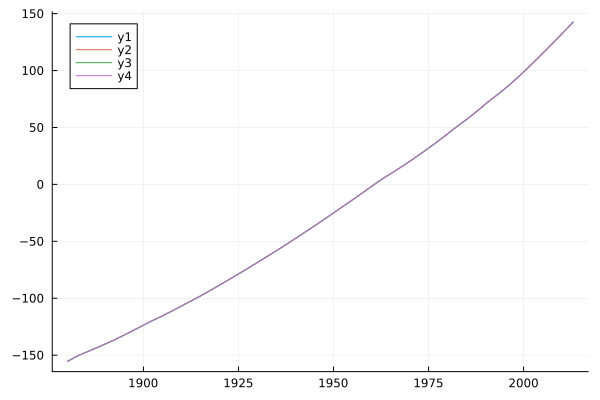

In [75]:
rcp_calib26 = rahmstorf_model(params[1], params[2], params[3], temps_array[1])[1:length(years)]
rcp_calib45 = rahmstorf_model(params[1], params[2], params[3], temps_array[2])[1:length(years)]
rcp_calib60 = rahmstorf_model(params[1], params[2], params[3], temps_array[3])[1:length(years)]
rcp_calib85 = rahmstorf_model(params[1], params[2], params[3], temps_array[4])[1:length(years)]
plot(years,rcp_calib26)
plot!(years,rcp_calib45)
plot!(years,rcp_calib60)
plot!(years,rcp_calib85)

#### Problem 2.3 (10 points)

Use [`Plots.density()`](https://docs.juliaplots.org/latest/api/#Plots.density!-Tuple) to plot the distribution of global mean sea levels in 2100 for each RCP (put these density plots on the same axes for easier comparison).

#### Problem 2.4 (10 points)

What do you notice about the contributions of parametric and scenario uncertainty to the variability in sea levels over the rest of the century? Are there any interesting trends?

Both the parametric and scenario uncertainty appear to share several similarities. This might imply that the parametric and scenario analysis were set up in a similar manner. 